# UQ Problem for Predator-Prey Model

We assume that only the initial condition $\mathbf{u}_0$ is uncertain, i.e. unknown. We are interested in estimating $\mathbb{E}[u_1(T)]$ at time $T>0$ (number of predator at time $T$) using the Monte Carlo (MC) method.

## Region of initial conditions

For simplicity we set $\theta_1=\theta_2=\theta_{12}=\theta_{21}=1$. We consider the following perturbation of the initial condition:
$\mathbf{u}_0 \sim \mathcal{U}(\Gamma)$ where $\Gamma$ is definied as the square around the true initial condition $\bar{u}_0$ with perturbation radius $\delta$

\begin{equation}
\Gamma = \bar{u}_0 + [-\delta,\delta]^2.
\end{equation}

For the simulation we fix $\bar{u}_0 = (0.5, 2)'$ and $\delta = 0.2$. We generate initial conditions following the uniform distribution $\mathcal{U}(\Gamma)$ and plot this region of inital conditions. The random sampling of initial conditions is the first step that we need for the MC simulation.

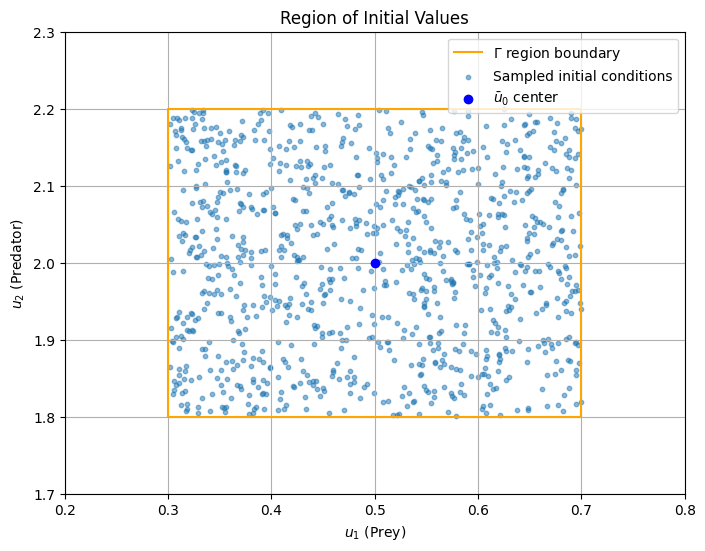

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Define the Lotka-Volterra model u1 prey, u2 predator
def lotka_volterra(t, u, theta1, theta2, theta12, theta21):
    u1, u2 = u
    du1dt = theta1 * u1 - theta12 * u1 * u2
    du2dt = theta21 * u1 * u2 - theta2 * u2
    return [du1dt, du2dt]

# Set parameters
theta1 = theta2 = theta12 = theta21 = 1
u0_bar = np.array([0.5, 2]) # unperturbed initial condition
delta = 0.2
T = 6
N = 1000  # Number of Monte Carlo samples
np.random.seed(42)

## Monte Carlo simulation

# Generate samples (initial conditions) following the uniform distirbution
initial_conditions = u0_bar + delta * (2 * np.random.rand(N, 2) - 1) # MC samples

# Define the sample (square) region vertices
square_vertices = np.array([
    [u0_bar[0] - delta, u0_bar[1] - delta],
    [u0_bar[0] + delta, u0_bar[1] - delta],
    [u0_bar[0] + delta, u0_bar[1] + delta],
    [u0_bar[0] - delta, u0_bar[1] + delta],
    [u0_bar[0] - delta, u0_bar[1] - delta]
])

# Plot the region with sampled initial conditions
plt.figure(figsize=(8, 6))
plt.plot(square_vertices[:, 0], square_vertices[:, 1], 'orange', label=r'$\Gamma$ region boundary')
plt.scatter(initial_conditions[:, 0], initial_conditions[:, 1], s=10, alpha=0.5, label='Sampled initial conditions')
plt.scatter(u0_bar[0], u0_bar[1], color='blue', zorder=5, label=r'$\bar{u}_0$ center')

plt.xlabel(r'$u_1$ (Prey)')
plt.ylabel(r'$u_2$ (Predator)')
plt.title('Region of Initial Values')
plt.legend()
plt.grid(True)
plt.xlim([u0_bar[0] - delta - 0.1, u0_bar[0] + delta + 0.1])
plt.ylim([u0_bar[1] - delta - 0.1, u0_bar[1] + delta + 0.1])
plt.show()

## MC estimator for $\mathbb{E}[u_1(T)]$

For the next step of the MC simulation we solve the ODE for each sampled initial condition. Therefore we use the function *'sol_ivp'* from *'scipy.integrate'*. The argument 'method=RK45' is used to numerically integrate the ODE, which is reasonable since it provides a good balance between accuracy and computational cost. We give a plot of the obtained function values $u_1(t=T)$ at a fix $T=6$ and mark the mean i.e. the MC estimator. 

MC estimator for expected value of u1(T) at T=6: 1.5181587659330416
Value of u1(T) for the unperturbed trajectory for T=6: 1.4098300518932472


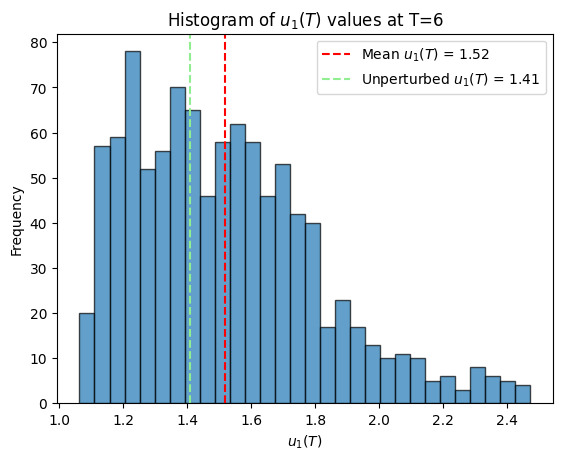

In [5]:
from scipy.integrate import solve_ivp # for solving the ode

# Solve ODE for each initial condition
u1_T_values = [] # list for storing values of u1(T), i.e. prey, at T=6
for u0 in initial_conditions:
    sol = solve_ivp(lotka_volterra, [0, T], u0, args=(theta1, theta2, theta12, theta21), method='RK45', t_eval=[T])
    u1_T_values.append(sol.y[0, 0]) 
    
# Calculate MC estimator
u1_T_mean = np.mean(u1_T_values)
print(f"MC estimator for expected value of u1(T) at T={T}: {u1_T_mean}")

# Solve ODE for the unperturbed initial condition
sol_unperturbed = solve_ivp(lotka_volterra, [0, T], u0_bar, args=(theta1, theta2, theta12, theta21), method='RK45', t_eval=[T])
print(f"Value of u1(T) for the unperturbed trajectory for T=6: {sol_unperturbed.y[0, 0]}")

# Plot results
plt.hist(u1_T_values, bins=30, edgecolor='k', alpha=0.7)
plt.axvline(u1_T_mean, color='r', linestyle='--', label=f"Mean $u_{1}(T)$ = {u1_T_mean:.2f}")
plt.axvline(sol_unperturbed.y[0, 0], color='lightgreen', linestyle='--', label=f"Unperturbed $u_{1}(T)$ = {sol_unperturbed.y[0, 0]:.2f}")
plt.xlabel("$u_{1}(T)$")
plt.ylabel("Frequency")
plt.title(f"Histogram of $u_{1}(T)$ values at T={T}")
plt.legend()
plt.show()

We give now a plot of the true unperturbed trajectory (green) and ten perturbed trajectories (grey). The endpoints (blue) represent the value of $\textbf{u}(T)$.

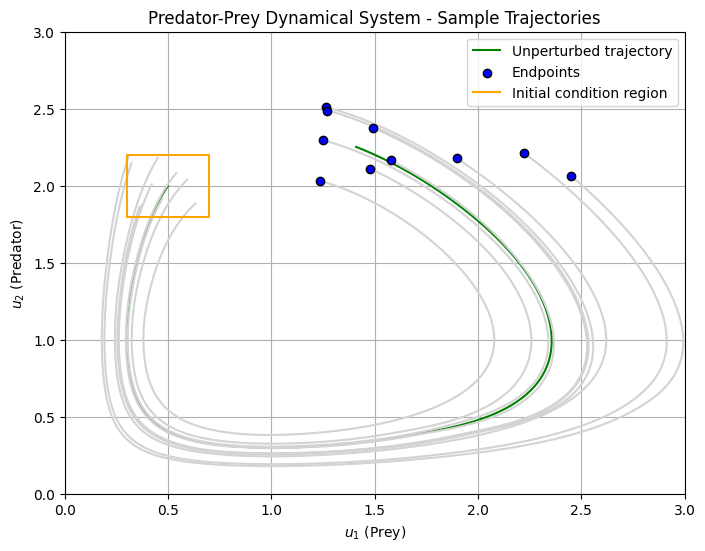

In [6]:
N = 10  # Number of perturbed trajectories
np.random.seed(42)

# Generate sampled (perturbed) initial conditions
initial_conditions = u0_bar + delta * (2 * np.random.rand(N, 2) - 1)

# Solve ODE for the unperturbed initial condition for 300 evenly spaced points in time in [0,T=6]
sol_unperturbed = solve_ivp(lotka_volterra, [0, T], u0_bar, args=(theta1, theta2, theta12, theta21), method='RK45', t_eval=np.linspace(0, T, 300))

# Solve ODE for each initial condition for 300 evenly spaced points in time in [0,T=6]
trajectories = []
endpoints = []
for u0 in initial_conditions:
    sol = solve_ivp(lotka_volterra, [0, T], u0, args=(theta1, theta2, theta12, theta21), method='RK45', t_eval=np.linspace(0, T, 300))
    trajectories.append(sol)
    endpoints.append([sol.y[0, -1], sol.y[1, -1]])

endpoints = np.array(endpoints)

# Define the sample (square) region vertices
square_vertices = np.array([
    [u0_bar[0] - delta, u0_bar[1] - delta],
    [u0_bar[0] + delta, u0_bar[1] - delta],
    [u0_bar[0] + delta, u0_bar[1] + delta],
    [u0_bar[0] - delta, u0_bar[1] + delta],
    [u0_bar[0] - delta, u0_bar[1] - delta]
])

# Plot
plt.figure(figsize=(8, 6))
plt.plot(sol_unperturbed.y[0], sol_unperturbed.y[1], 'g-', label='Unperturbed trajectory') # unperturbed trajectory
for sol in trajectories:
    plt.plot(sol.y[0], sol.y[1], 'lightgray') # perturbed trajectories
plt.scatter(endpoints[:, 0], endpoints[:, 1], color='blue', edgecolor='k', zorder=5, label='Endpoints') # value u(T)
plt.plot(square_vertices[:, 0], square_vertices[:, 1], 'orange', label='Initial condition region') # initial region

plt.xlabel(r'$u_1$ (Prey)')
plt.ylabel(r'$u_2$ (Predator)')
plt.title('Predator-Prey Dynamical System - Sample Trajectories')
plt.legend()
plt.grid(True)
plt.xlim([0, 3])
plt.ylim([0, 3])
plt.show()